In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
from fbprophet import Prophet



ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


The 3 greatest lines in history. Took so long to figure it out


Installing collected packages: fbprophet
    Running setup.py install for fbprophet ... done
Successfully installed fbprophet-0.5

In [3]:
productDemand = pd.read_csv("./data/Historical Product Demand.csv")
productDemand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Drop any row that is has null values/ Lets Clean the data...

In [4]:
productDemand.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False).head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Makes the date object a datetime vs an object

In [ ]:
productDemand['Date'] = pd.to_datetime(productDemand['Date'])
productDemand.dtypes

lable encoding to fix the data

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(productDemand['Product_Code'])
productDemand['Product_Code'] = le.transform(productDemand['Product_Code'])
le.fit(productDemand['Warehouse'])
productDemand['Warehouse'] = le.transform(productDemand['Warehouse'])
le.fit(productDemand['Product_Category'])
productDemand['Product_Category'] = le.transform(productDemand['Product_Category'])
productDemand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,982,2,27,2012-07-27,100
1,968,2,27,2012-01-19,500
2,968,2,27,2012-02-03,500
3,968,2,27,2012-02-09,500
4,968,2,27,2012-03-02,500


Create the prediction objects

In [8]:
from sklearn.model_selection import train_test_split
my_pred = productDemand['Order_Demand']
pd.DataFrame(my_pred).fillna(0).head()

,Order_Demand
0,100
1,500
2,500
3,500
4,500


Establish the features we want to guess on.

In [9]:
df_features = productDemand[['Product_Code', 'Warehouse', 'Product_Category', 'Date' ]]
df_features = df_features.dropna()
pd.DataFrame(df_features).fillna(0).head()

,Product_Code,Warehouse,Product_Category,Date
0,982,2,27,2012-07-27
1,968,2,27,2012-01-19
2,968,2,27,2012-02-03
3,968,2,27,2012-02-09
4,968,2,27,2012-03-02


let's start by graccing the product code which is 1. After that let's clean it up to use Prophet. In this case the order_demand needs to be an number rather than an object

In [23]:
productDemand.sort_values(by=['Product_Code'])
my_data = productDemand.loc[productDemand['Product_Code'] == 1 ]
final = my_data[['Date', 'Order_Demand']]
final['Order_Demand'] = pd.to_numeric(final['Order_Demand'], errors='coerce')
final.head()

,Date,Order_Demand
3961,2012-03-01,50000.0
3963,2012-05-02,50000.0
3965,2012-07-03,30000.0
3967,2012-09-05,10000.0
3969,2012-11-08,30000.0


Prophet can only take in columns that are called ds and y, which is in this case y is order demand and ds is the date. We also are going to log the data to make sure it is consisten and we reduce the number of outliers in the dataset or negatives.

In [24]:
final.rename(columns={ "Order_Demand": "y"}, inplace = True)
final['y'] = np.around(np.log(final['y']), decimals =4)
final = final.sort_values(by=['Date'])
final.set_index('Date')
final.head()

,Date,y
42127,2011-12-23,6.9078
76195,2011-12-23,8.5172
15120,2011-12-26,12.2061
41993,2011-12-28,9.2103
41289,2011-12-28,8.5172


Clean for any infinities in the data

In [25]:
final = final.resample('M', on='Date').mean()
final['ds'] = final.index
final = final[~final.isin([np.nan, np.inf, -np.inf]).any(1)]

final.head()

,y,ds
Date,,
2011-12-31,9.071720,2011-12-31
2012-01-31,9.515767,2012-01-31
2012-02-29,8.554967,2012-02-29
2012-03-31,9.714050,2012-03-31
2012-04-30,8.969540,2012-04-30


Here we are doing our prophet model. We are using yearly seasonality and predicting several days into the future. We can see the general trend lines and predict the future of the product

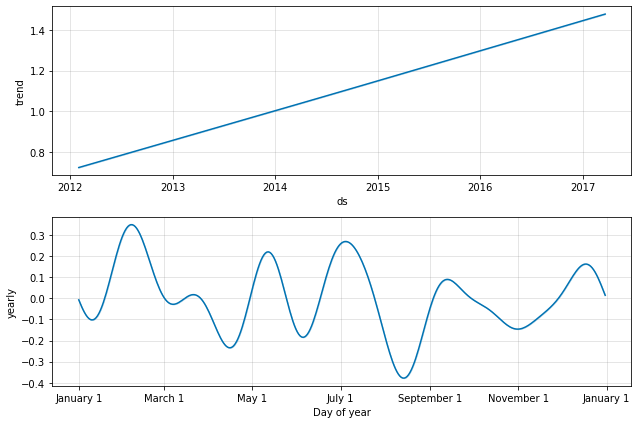

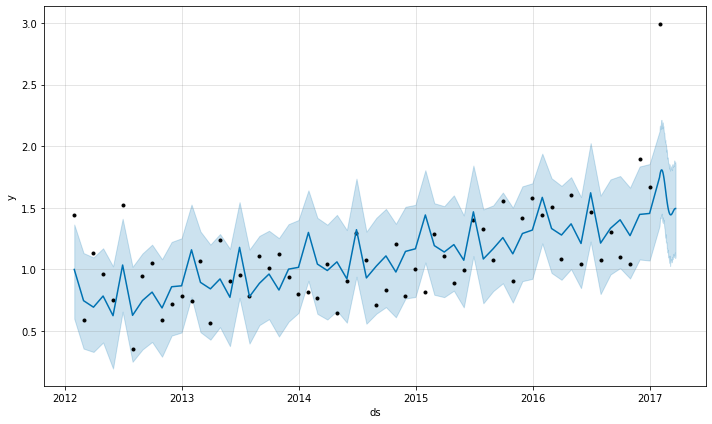

In [32]:
m = Prophet(yearly_seasonality = True,weekly_seasonality=False,daily_seasonality=False, seasonality_prior_scale=0.1)
m.fit(final)
future = m.make_future_dataframe(periods=50)
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters()

m.plot_components(forecast)
fig1 = m.plot(forecast)


Here we can get the RMSE values which allows us to predict how accurate our prediction was to the actual. We have a pretty high RMSE.

In [27]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-01-11 00:00:00 and 2016-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,horizon,mse,rmse,mae,mape,coverage
0,48 days,0.381311,0.617504,0.529492,0.057447,0.500000
1,52 days,0.420784,0.648678,0.557790,0.060643,0.500000
2,53 days,0.640136,0.800085,0.693598,0.073001,0.333333
3,57 days,0.805001,0.897218,0.806830,0.083874,0.166667
4,59 days,1.417173,1.190451,1.110262,0.110974,0.000000


In [36]:
unique_products = productDemand.Product_Code.unique()

for item in unique_products:
    my_data = productDemand.loc[productDemand['Product_Code'] == item ]
#     final = my_data[['Date', 'Order_Demand']]
#     final['Order_Demand'] = pd.to_numeric(final['Order_Demand'], errors='coerce')
#     final.rename(columns={ "Order_Demand": "y"}, inplace = True)
#     final['y'] = np.around(np.log(final['y']), decimals =4)
#     final = final.sort_values(by=['Date'])
#     final.set_index('Date')
#     final = final.resample('M', on='Date').mean()
#     final['ds'] = final.index
#     final = final[~final.isin([np.nan, np.inf, -np.inf]).any(1)]
#     m = Prophet(yearly_seasonality = False,weekly_seasonality=True,daily_seasonality=False, seasonality_prior_scale=0.1)
#     m.fit(final)
#     future = m.make_future_dataframe(periods=10)
#     forecast = m.predict(future)
#     pd.plotting.register_matplotlib_converters()

#     m.plot_components(forecast)
#     fig1 = m.plot(forecast)


    



All in all, we can run the prophet model for all of our time series prediciton models. The software actually was the greatest barrier as I was running this on my windows machine. The graphs and the trend lines are really informative and paint a story as to which item categories have a high seasonality and which ones don't. We can in the future take into account holidays, which prophet has built into their API.